In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KernelDensity
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import validation_curve
from scipy import stats

In [12]:
df_eng = pd.read_csv('tutor_data.csv').drop(columns='Unnamed: 0')

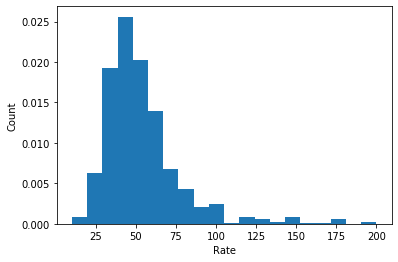

In [13]:
plt.hist(df_eng.rate, bins=20, range=(10,200), density=True)
plt.xlabel('Rate')
plt.ylabel('Count')
plt.show()

In [5]:
df_eng.describe()

,rate,hours_sun,hours_mon,hours_tues,hours_wed,hours_thurs,hours_fri,hours_sat,hours_per_week_schedule,hours_per_week_estimate,descriptions_length,bio_length,number_subjects,number_degrees
count,2493.000000,2493.000000,2493.000000,2493.000000,2493.000000,2493.000000,2493.000000,2493.000000,2493.000000,2493.000000,2493.000000,2493.000000,2493.000000,2493.000000
mean,54.533093,8.583634,8.427998,8.845568,8.845568,8.941837,8.740473,9.385078,61.770156,2.926775,49.863618,1400.248295,15.189731,1.821500
std,35.139841,5.814336,5.425193,5.331376,5.331376,5.273825,5.406401,5.621713,33.013418,5.821007,15.458530,518.562542,9.788765,0.795142
min,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005004,9.000000,235.000000,1.000000,0.000000
25%,39.000000,4.000000,4.000000,5.000000,5.000000,5.000000,4.000000,5.000000,37.000000,0.501674,38.000000,961.000000,8.000000,1.000000
50%,49.000000,9.000000,8.000000,9.000000,9.000000,9.000000,9.000000,10.000000,58.000000,1.320175,53.000000,1413.000000,13.000000,2.000000
75%,60.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,13.000000,81.000000,3.407895,63.000000,1977.000000,20.000000,2.000000
max,500.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,168.000000,189.000000,70.000000,2048.000000,102.000000,3.000000


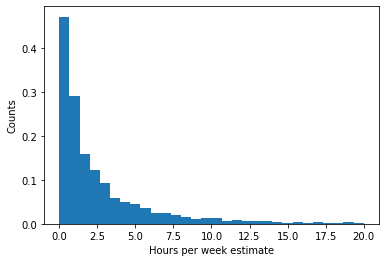

In [14]:
plt.hist(df_eng.hours_per_week_estimate, bins=30, range=(0,20), density=True)
plt.xlabel('Hours per week estimate')
plt.ylabel('Counts')
plt.show()

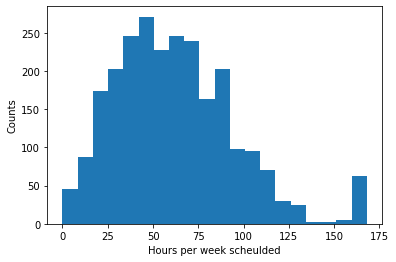

In [5]:
plt.hist(df_eng.hours_per_week_schedule, bins=20)
plt.xlabel('Hours per week scheulded')
plt.ylabel('Counts')
plt.show()

In [15]:
def string_to_list(i):
    x = i.replace('[', '').replace(']', '').replace('\'', '').split(',')
    list_i = list()
    for j in x:
        list_i.append(j.lstrip().rstrip())
    return list_i

subjects_all_list = []
for i in df_eng['subjects_all']:
    subjects_all_list.append(string_to_list(i))
df_eng['subjects_list'] = np.array(subjects_all_list)

subjects_emph_list = []
for i in df_eng['subjects_emph']:
    subjects_emph_list.append(string_to_list(i))
df_eng['subjects_emph_list'] = np.array(subjects_emph_list)

#edu_list = []
#for i in df_eng['edu']:
#    edu_list.append(string_to_list(i))
#df_eng['edu_list'] = np.array(edu_list)

#df_eng.drop(columns=['subjects_all','subjects_emph'], inplace=True)

In [16]:
# engineer subjects categories
feature = 'subjects_list'
size_subjects = len(df_eng[feature].explode().value_counts().index)
popular_subjects = list(df_eng[feature].explode().value_counts().index[:size_subjects//3])
mid_subjects = list(df_eng[feature].explode().value_counts().index[size_subjects//3:(size_subjects//3 + size_subjects//3)])
unpopular_subjects = list(df_eng[feature].explode().value_counts().index[(size_subjects//3 + size_subjects//3):])

unwanted = ''
if unwanted in popular_subjects:
    popular_subjects.remove(unwanted)
elif unwanted in mid_subjects:
    mid_subjects.remove(unwanted)
elif unwanted in unpopular_subjects:
    unpopular_subjects.remove(unwanted)

popular_list = []
mid_list = []
unpopular_list = []
for f in df_eng[feature]:
    num_popular = 0
    num_mid = 0
    num_unpopular = 0
    for j in f:
        if j in popular_subjects:
            num_popular += 1
        elif j in mid_subjects:
            num_mid += 1
        elif j in unpopular_subjects:
            num_unpopular += 1
    popular_list.append(num_popular)
    mid_list.append(num_mid)
    unpopular_list.append(num_unpopular)
df_eng['num_popular_subjects'] = np.array(popular_list)
df_eng['num_mid_subjects'] = np.array(mid_list)
df_eng['num_unpopular_subjects'] = np.array(unpopular_list)

In [17]:
# engineer edu degree categories

undergrad = ['BA', 'B.A.', 'BS', 'B.S.', '']
postgrad = ['MS', 'M.S', 'MA', 'M.A', 'masters', 'Masters', 'CA', 'C.A', 
            'MBA', 'M.B.A', 'MD', 'M.D', 'PhD', 'Ph.D', 'Ph.D.', 'Graduate']
certified = ['education', 'Ced', 'certified']

undergrad_degree = []
postgrad_degree = []
certified_degree = []
for e in df_eng['edu']:
    undergrad_count = 0
    postgrad_count = 0
    certified_count = 0
    if any(x in e for x in undergrad):
        undergrad_count += 1
    if any(x in e for x in postgrad):
        postgrad_count += 1
    if any(x in e for x in certified):
        certified_count +=1
    undergrad_degree.append(undergrad_count)
    postgrad_degree.append(postgrad_count)
    certified_degree.append(certified_count)
df_eng['undergrad_degree'] = np.array(undergrad_degree)
df_eng['postgrad_degree'] = np.array(postgrad_degree)
df_eng['certified_degree'] = np.array(certified_degree)

In [18]:
# get university rankings
df_wur = pd.read_csv('world-university-rankings_cwurData.csv')
df_wur_select = df_wur[['institution', 'world_rank']]

list_of_top_schools = (list(df_wur_select['institution'][:30]) + 
['Berkeley', 'Caltech', 'Harvard', 'Yale', 'Princeton', 'MIT', 'Stanford'])

top_school = []
for e in df_eng['edu']:
    top = 0
    if any(x in e for x in list_of_top_schools):
        top += 1
    top_school.append(top)
df_eng['top_school'] = np.array(top_school)

In [11]:
#cols_to_drop = ['descriptions', 'bio', 'subjects_list', 'subjects_emph_list', 'edu', 'bg_check_date', 'earliest_review_date']

In [19]:
target = 'hours_per_week_estimate'
X = df_eng.drop(columns=target)
y = df_eng[target]

In [13]:
def score_CV(model, data, y, metric):
    score = cross_val_score(model, data, y, cv=5, scoring=metric)
    print(metric, 'mean:', '%.2f'%np.mean(score))

In [15]:
knn = KNeighborsRegressor(weights='distance', n_neighbors = 15)
scores = score_CV(knn, X, y, 'neg_mean_squared_error')

neg_mean_squared_error mean: -32.02


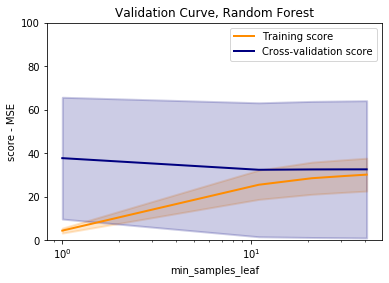

In [111]:
rf = RandomForestRegressor(n_estimators=50, criterion='mse', random_state=0)
# Plot validation curve
param_range = np.arange(1,51,10)
train_scores, valid_scores = validation_curve(rf, X, y, 'min_samples_leaf', 
                                              param_range, cv=5, scoring='neg_mean_squared_error')

train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = -np.std(train_scores, axis=1)
valid_scores_mean = -np.mean(valid_scores, axis=1)
valid_scores_std = -np.std(valid_scores, axis=1)

plt.title("Validation Curve, Random Forest")
plt.xlabel('min_samples_leaf')
plt.ylabel("score - MSE")
plt.ylim(0, 100)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, valid_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, valid_scores_mean - valid_scores_std,
                 valid_scores_mean + valid_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

Feature ranking:
feature rate (0.18)
feature number_subjects (0.11)
feature bio_length (0.10)
feature hours_sat (0.10)
feature hours_per_week_schedule (0.09)
feature descriptions_length (0.08)
feature num_popular_subjects (0.06)
feature hours_thurs (0.04)
feature hours_tues (0.04)
feature hours_sun (0.04)
feature hours_mon (0.04)
feature hours_wed (0.04)
feature num_mid_subjects (0.03)
feature hours_fri (0.02)
feature num_unpopular_subjects (0.01)
feature number_degrees (0.01)
feature top_school (0.01)
feature postgrad_degree (0.01)
feature certified_degree (0.00)
feature undergrad_degree (0.00)


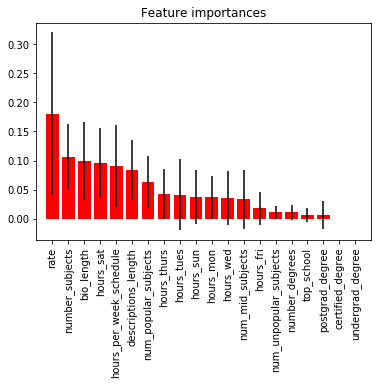

In [17]:
rf = RandomForestRegressor(n_estimators=50, criterion='mse', min_samples_leaf=10, random_state=0)
y = df_eda['hours_per_week_estimate']
features = list(X.columns)
rf.fit(X, y)
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print feature ranking
print("Feature ranking:")
test = [features[f] for f in indices]
for f in range(X.shape[1]):
    print("feature %s (%.2f)" %(test[f], importances[indices[f]]))

# Plot feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), test, rotation='vertical')
plt.xlim([-1, X.shape[1]])
plt.show()

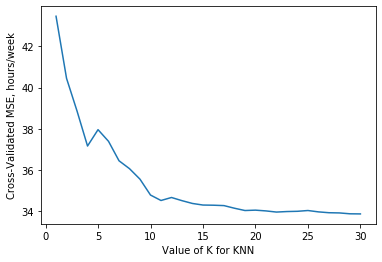

In [56]:
k_range = range(1, 31)
k_scores = []
X_top = X[test[:6]]
for k in k_range:
    knn = KNeighborsRegressor(n_neighbors=k, algorithm='ball_tree',
    metric='euclidean')
    loss = abs(cross_val_score(knn, X_top, y, cv=5, scoring='neg_mean_squared_error'))
    k_scores.append(loss.mean())
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated MSE, hours/week')
plt.show()

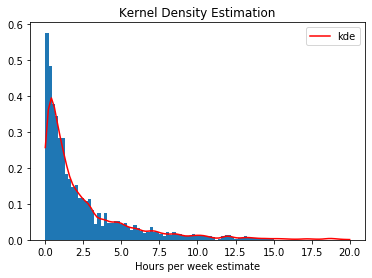

In [59]:
# Kernel density estimate
gkde = stats.gaussian_kde(y, bw_method = 0.05, weights=None)
ind = np.linspace(0,20,101)
kdepdf = gkde.evaluate(ind)
#plt.figure()
# plot histgram of sample
plt.hist(y, bins=70, range=(0,15), density=True)
plt.xlabel('Hours per week estimate')
# plot data generating density
# plt.plot(ind, stats.norm.pdf(ind), color="r", label='DGP normal')
# plot estimated density
plt.plot(ind, kdepdf, label='kde', color="r")
plt.title('Kernel Density Estimation')
plt.legend()
plt.show()